# Linear Regression Model

## Start Spark Session

In [1]:
import boto3
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql import Window

spark = SparkSession.builder \
    .appName("Inference") \
    .getOrCreate()

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.7 
Trying to create a Glue session for the kernel.
Session Type: etl
Session ID: d682522b-addf-43b7-81cf-fdc2e64ff94e
Applying the following default arguments:
--glue_kernel_version 1.0.7
--enable-glue-datacatalog true
Waiting for session d682522b-addf-43b7-81cf-fdc2e64ff94e to get into ready status...
Session d682522b-addf-43b7-81cf-fdc2e64ff94e has been created.



In [2]:
%session_id 

Current active Session ID: d682522b-addf-43b7-81cf-fdc2e64ff94e


## Set up Model

In [2]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, lag, lead
from pyspark.ml import Pipeline

In [3]:
bucket_name = "crypto-marketdata-marketdatabucket-m13jkiz8o4p7"
btc_processed_file_path = "s3://{}/marketdata/processed_crypto/BTCUSDT-*-processed.parquet".format(bucket_name)

In [4]:
# load processed data
btc_processed_data = spark.read.parquet(btc_processed_file_path)
btc_processed_data = btc_processed_data.orderBy("close_time")

In [20]:
btc_processed_data.head(1)

[Row(close_time=datetime.datetime(2021, 1, 1, 1, 59, 59, 999000), open_time=datetime.datetime(2021, 1, 1, 1, 0), open=28995.13, high=29470.0, low=28960.35, close=29409.99, vol=5403.068471, quote_asset_vol=158357816.8180572, number_of_trades=103896, taker_base_asset_vol=3160.041701, taker_quote_asset_vol=92613991.93555292, ignore=0, ticker='BTCUSDT', SMA_240=29409.99, SMA_480=29409.99, RSI=None, Middle_Band=29409.99, STD=None, Upper_Band=None, Lower_Band=None)]


### Linear Regression

In [5]:
# Create the label (Next Close)
window = Window.orderBy("close_time")
btc_data_with_label = btc_processed_data.withColumn("Next_Close", F.lead("close").over(window))

In [6]:
# Drop rows with null values
btc_data_with_label = btc_data_with_label.dropna()

In [51]:
btc_data_with_label.tail(1)

[Row(close_time=datetime.datetime(2024, 10, 31, 22, 59, 59, 999000), open_time=datetime.datetime(2024, 10, 31, 22, 0), open=70442.39, high=70543.98, low=70174.09, close=70480.0, vol=702.79368, quote_asset_vol=49452281.9668954, number_of_trades=131817, taker_base_asset_vol=315.02408, taker_quote_asset_vol=22168424.9433087, ignore=0, ticker='BTCUSDT', SMA_240=68758.80058333333, SMA_480=67591.94845833333, RSI=52.62282794550012, Middle_Band=67591.94845833333, STD=2445.583437893513, Upper_Band=72483.11533412035, Lower_Band=62700.7815825463, Next_Close=70292.01)]


#### Observe the correlation between features and close price

In [7]:
features = ['open', 'high', 'low', 'vol', 'quote_asset_vol', 
            'number_of_trades', 'taker_base_asset_vol', 
            'taker_quote_asset_vol', 'SMA_240', 'SMA_480', 'RSI', 
            'Middle_Band', "STD", "Upper_Band", "Lower_Band"]

btc_data_with_label_df = btc_data_with_label.select("close_time", *features, "Next_Close").toPandas()

In [50]:
btc_data_with_label_df.columns

Index(['close_time', 'open', 'high', 'low', 'vol', 'quote_asset_vol',
       'number_of_trades', 'taker_base_asset_vol', 'taker_quote_asset_vol',
       'SMA_240', 'SMA_480', 'RSI', 'Middle_Band', 'STD', 'Upper_Band',
       'Lower_Band', 'Next_Close'],
      dtype='object')


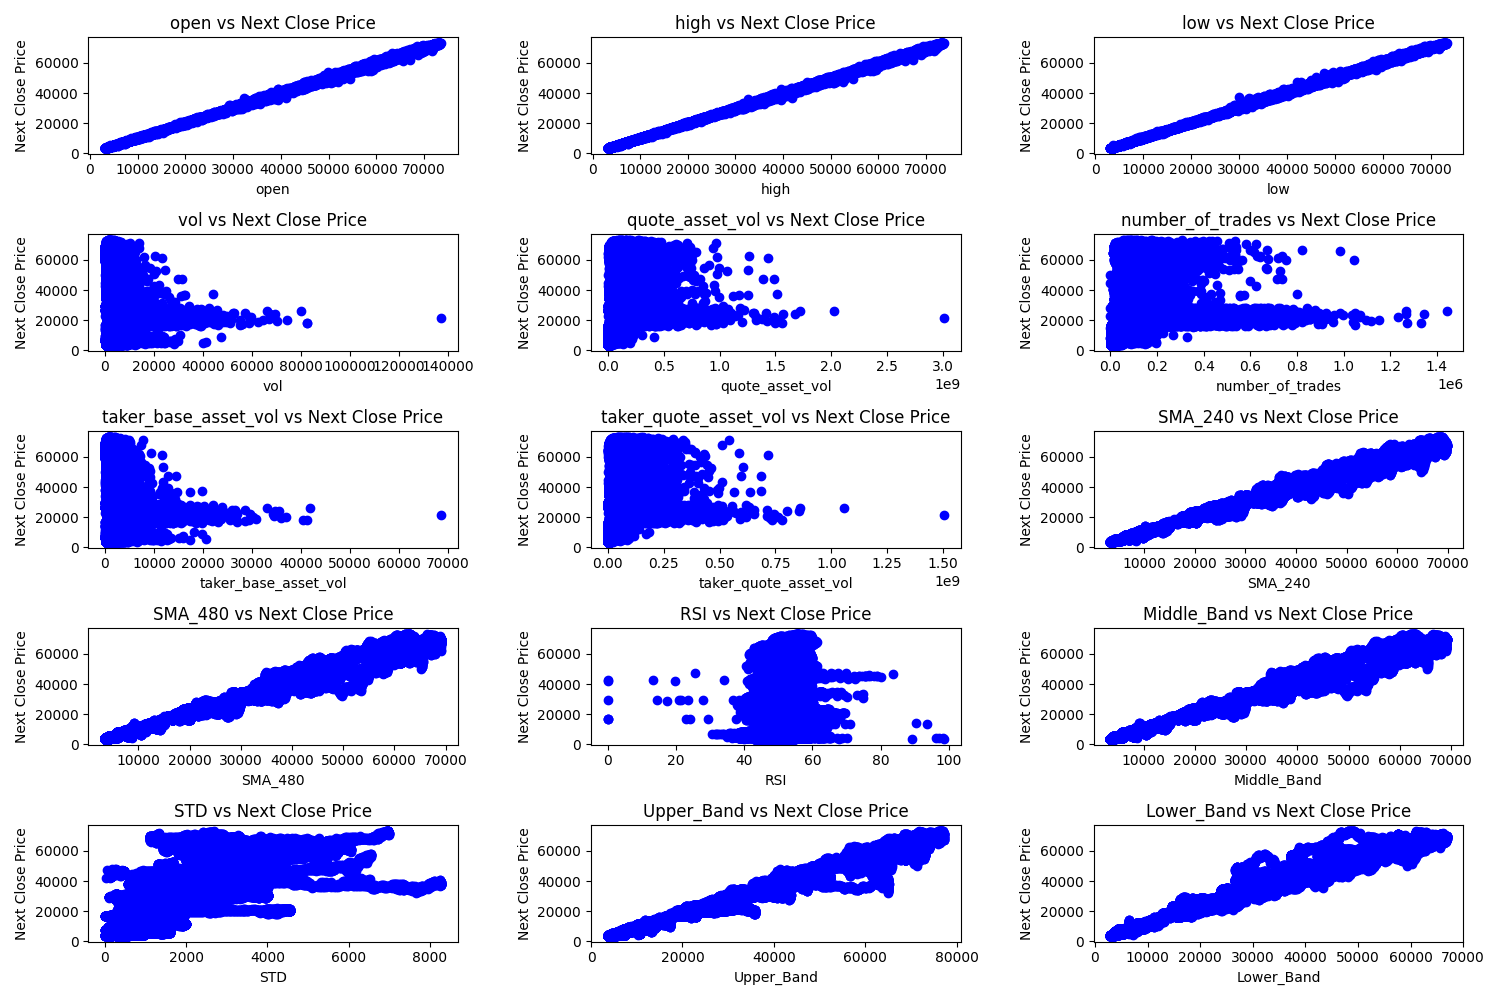

In [25]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(len(features)//3, 3, i + 1)  
    plt.scatter(btc_data_with_label_df[feature], btc_data_with_label_df['Next_Close'], color='blue')
    plt.title(f'{feature} vs Next Close Price')
    plt.xlabel(feature)
    plt.ylabel('Next Close Price')

plt.tight_layout(w_pad=3)
plt.show()
%matplot plt

#### Train the model

In [8]:
# Prepare features and label
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(btc_data_with_label).select("close_time", "features", "Next_Close")

In [9]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=4651)

In [10]:
lr = LinearRegression(labelCol="Next_Close", maxIter=10)
lr_model = lr.fit(train_data)

In [56]:
predictions = lr_model.transform(test_data)

predictions.select("Next_Close", "prediction").show()

+----------+------------------+
|Next_Close|        prediction|
+----------+------------------+
|  13780.41|16111.289608294952|
|  13499.99|14893.102462722094|
|   13022.0|12718.144714580922|
|   13135.0|12638.753611242366|
|  13240.37|12814.343207157952|
|  13399.24|13064.938251586293|
|   13522.0|13868.654252799908|
|  14818.49|15342.772207008562|
|  15019.66|15346.172802840385|
|  14455.55|14988.062692492447|
|  14855.02|14720.866296783723|
|  15010.06| 15048.16925087915|
|  14700.01|14859.254594791964|
|  14926.01|14806.120219517816|
|  15119.97| 15328.41519608289|
|   14875.1| 15140.96479883551|
|  14353.01| 14610.94655818318|
|  14648.89|14502.415248678248|
|  14906.01| 15076.36452780166|
|  14965.37|15191.272168296127|
+----------+------------------+
only showing top 20 rows


In [57]:
test_results = lr_model.evaluate(test_data)

print(f"RMSE: {test_results.rootMeanSquaredError}")
print(f"R2: {test_results.r2}")

RMSE: 688.4890623805968
R2: 0.9988012841268906


#### Observe the coefficient value

In [63]:
# Output the coefficients and intercept
coefficients = lr_model.coefficients
intercept = lr_model.intercept

# Create a list of feature names and their corresponding coefficients
feature_names = features
results = [(feature_names[i], coefficients[i]) for i in range(len(coefficients))]

print("Intercept:", intercept)
for feature, coef in results:
    print(f"Feature: {feature}, Coefficient: {coef}")

Intercept: -3934.798429820473
Feature: open, Coefficient: 0.2504020264355401
Feature: high, Coefficient: 0.2480650766295165
Feature: low, Coefficient: 0.2566104628208285
Feature: vol, Coefficient: 0.0833880260892058
Feature: quote_asset_vol, Coefficient: -5.4408632137922944e-06
Feature: number_of_trades, Coefficient: -0.002909611183088466
Feature: taker_base_asset_vol, Coefficient: 0.3090386475979662
Feature: taker_quote_asset_vol, Coefficient: -2.607564157219692e-07
Feature: SMA_240, Coefficient: 0.1010340387932982
Feature: SMA_480, Coefficient: 0.04186528870516549
Feature: RSI, Coefficient: 67.79654684927526
Feature: Middle_Band, Coefficient: 0.04186528870516549
Feature: STD, Coefficient: -0.13566743230996609
Feature: Upper_Band, Coefficient: 0.033578428077672015
Feature: Lower_Band, Coefficient: 0.05222761945291478


#### Plot the prediction vs actual close price

In [58]:
# Convert to Pandas DataFrame for plotting
predictions_pd = predictions.toPandas()

In [59]:
predictions_pd.tail(1)

                   close_time  ...    prediction
11836 2024-10-31 22:59:59.999  ...  70259.535434

[1 rows x 4 columns]


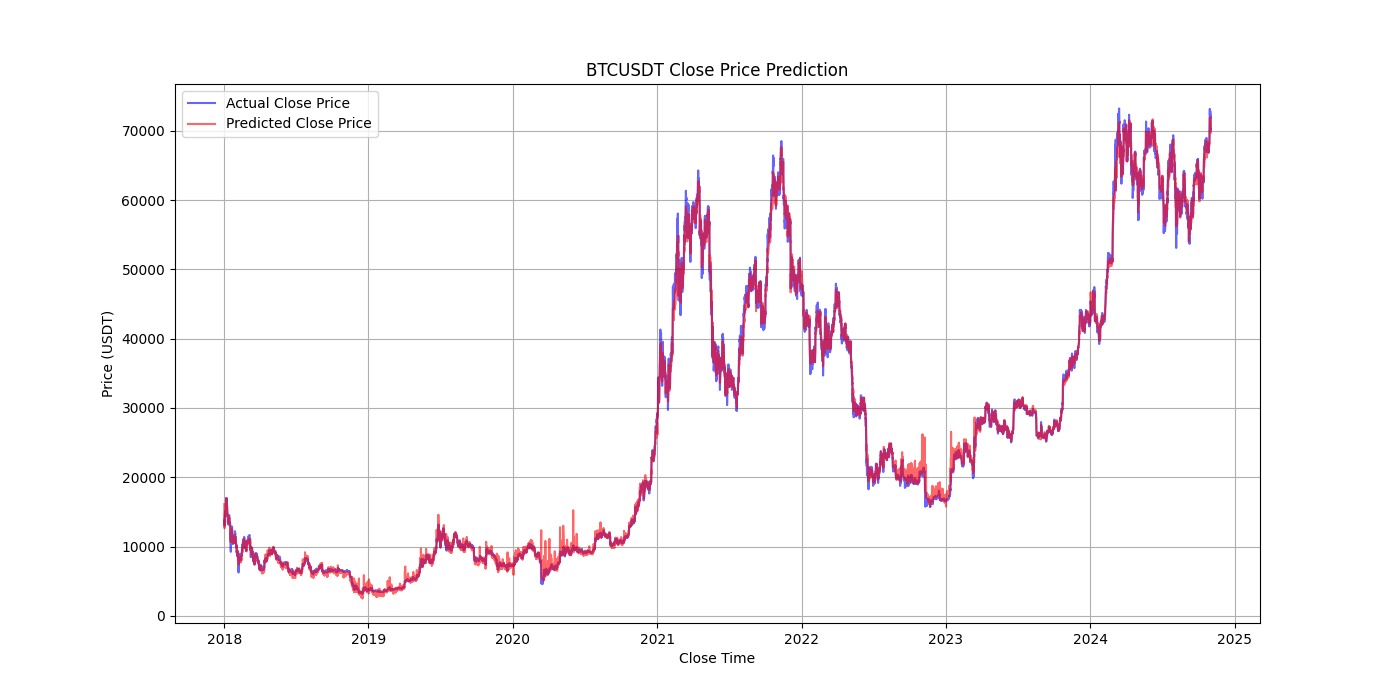

In [60]:
plt.figure(figsize=(14, 7))
plt.plot(predictions_pd["close_time"], predictions_pd["Next_Close"].values, label="Actual Close Price", color="blue", alpha=0.6)
plt.plot(predictions_pd["close_time"], predictions_pd["prediction"].values, label="Predicted Close Price", color="red", alpha=0.6)
plt.title("BTCUSDT Close Price Prediction")
plt.xlabel("Close Time")
plt.ylabel("Price (USDT)")
plt.legend()
plt.grid()
plt.show()

%matplot plt

In [14]:
lr_model.sav

In [6]:
%stop_session

Stopping session: 69f608eb-fcfe-4154-a3da-197c152470fd
Stopped session.
